In [11]:
import stim
import numpy as np
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import scipy.stats

In [14]:
def generate_qubit_coords(d):
    qubit_coords = {}
    qubit_index = 0

    # Data qubits on odd coordinates within 2d x 2d grid
    for y in range(1, 2 * d, 2):
        for x in range(1, 2 * d, 2):
            qubit_coords[(x, y)] = qubit_index
            qubit_index += 1

    # Ancilla qubits on even coordinates with specified conditions
    for y in range(0, 2 * d + 1, 2):
        for x in range(0, 2 * d + 1, 2):
            # Skip corner ancillas at (0, 0), (0, 2d), (2d, 0), and (2d, 2d)
            if (y == 0 and x == 0) or (y == 0 and x == 2 * d) or (y == 2 * d and x == 0) or (y == 2 * d and x == 2 * d):
                continue
            # Place ancillas on one edge at every even coordinate and the opposite edge in alternating fashion
            if y == 0 or y == 2 * d:
                if (x // 2) % 2 != (y // (2 * d)) % 2:
                    qubit_coords[(x, y)] = qubit_index
                    qubit_index += 1
            elif x == 0 or x == 2 * d:
                if (y // 2) % 2 == (x // (2 * d)) % 2:
                    qubit_coords[(x, y)] = qubit_index
                    qubit_index += 1
            else:
                qubit_coords[(x, y)] = qubit_index
                qubit_index += 1

    return qubit_coords

In [22]:
def build_surface_code_circuit(qubit_coords, distance,rounds=5, lookback_distance=1, noise=0.001)
    """
    指定された量子ビットの座標を使用して、表面コードの回路を構築し、
    測定の後にディテクターを追加します。シンドローム測定は MR を使用します。
    最初のアンシラ量子ビットのリセットは残します。SHIFT_COORDS を追加して、
    ディテクターの座標を時間方向にシフトします。

    Parameters:
    - qubit_coords: 量子ビットの座標とインデックスの辞書 {(x, y): qubit_index}
    - rounds: スタビライザー測定の繰り返し回数（デフォルトは5）
    - lookback_distance: ディテクターが見る測定結果の距離（デフォルトは1）

    Returns:
    - circuit: 構築された stim.Circuit オブジェクト
    """
    circuit = stim.Circuit()

    # データ量子ビットと補助量子ビットの分類
    data_qubits = {}
    ancilla_qubits = {}
    qubit_indices = {}

    for (x, y), qubit in qubit_coords.items():
        qubit_indices[qubit] = (x, y)
        if qubit <= distance**2-1:
            data_qubits[(x, y)] = qubit
        else:
            ancilla_qubits[(x, y)] = qubit
    
    # QUBIT_COORDS を回路に追加
    for qubit, (x, y) in qubit_indices.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

    # データ量子ビットとアンシラ量子ビットの初期化
    circuit.append("R", list(data_qubits.values()))
    circuit.append("X_ERROR", list(data_qubits.values()), noise)
    circuit.append("R", list(ancilla_qubits.values()))  # 最初のアンシラ量子ビットのリセット
    circuit.append("X_ERROR", list(ancilla_qubits.values()), noise)  # RESET で x エラー
    circuit.append("TICK")  # Reset の後に TICK

    num_ancilla = len(ancilla_qubits)  # アンシラ量子ビットの数
    total_measurements = 0  # 累積測定数の初期化

    # スタビライザー測定のラウンド
    for round_num in range(rounds):
        # MR を使用するため、ラウンド開始時のリセット操作は不要

        # X スタビライザーの補助量子ビットに H を適用
        x_ancillas = []
        for (x, y), ancilla in ancilla_qubits.items():
            if (x + y) % 4 != 0:
                x_ancillas.append(ancilla)
        x_ancillas = sorted(x_ancillas)
        circuit.append("H", x_ancillas)
        circuit.append("DEPOLARIZE1", x_ancillas, noise)  # H の後に depolarizing error
        circuit.append("TICK")  # H の後に TICK

        # X と Z スタビライザーの CNOT ゲートを収集
        x_cnot_ops = [[] for _ in range(4)]
        z_cnot_ops = [[] for _ in range(4)]

        # X スタビライザーの CNOT (制御: 補助, ターゲット: データ)
        for ancilla in x_ancillas:
            x_pos, y_pos = qubit_indices[ancilla]
            for idx, (dx, dy) in enumerate([(1, 1), (-1, 1), (1, -1), (-1, -1)]):
                nx, ny = x_pos + dx, y_pos + dy
                if (nx, ny) in data_qubits:
                    data = data_qubits[(nx, ny)]
                    x_cnot_ops[idx].append((ancilla, data))

        # Z スタビライザーの CNOT (制御: データ, ターゲット: 補助)
        z_ancillas = []
        z_stabilizer_targets = {}  # Zスタビライザーのターゲットデータ量子ビットを保存する辞書
        for (x, y), ancilla in ancilla_qubits.items():
            if (x + y) % 4 == 0:
                z_ancillas.append(ancilla)
        z_ancillas = sorted(z_ancillas)
        for ancilla in z_ancillas:
            x_pos, y_pos = qubit_indices[ancilla]
            z_stabilizer_targets[ancilla] = []  # ターゲットデータ量子ビットのリストを初期化
            for idx, (dx, dy) in enumerate([(1, 1), (1, -1), (-1, 1), (-1, -1)]):
                nx, ny = x_pos + dx, y_pos + dy
                if (nx, ny) in data_qubits:
                    data = data_qubits[(nx, ny)]
                    z_cnot_ops[idx].append((data, ancilla))
                    z_stabilizer_targets[ancilla].append(data)  # ターゲットデータ量子ビットを追加
        
        # X と Z スタビライザーの CNOT を同時に追加し、4tick で終了するようにする
        for idx in range(4):
            combined_cnot_ops = x_cnot_ops[idx] + z_cnot_ops[idx]
            if combined_cnot_ops:
                controls, targets = zip(*combined_cnot_ops)
                cnot_targets = [q for pair in zip(controls, targets) for q in pair]
                circuit.append("CNOT", cnot_targets)
                circuit.append("DEPOLARIZE2", cnot_targets, noise)  # CNOT の後に 2qubit depolarizing error
                circuit.append("TICK")  # CNOT の後に TICK

        # X スタビライザーの補助量子ビットに H を適用
        circuit.append("H", x_ancillas)
        circuit.append("DEPOLARIZE1", x_ancillas, noise)  # H の後に depolarizing error
        circuit.append("TICK")  # H の後に TICK

        # すべての補助量子ビットを MR で測定
        sorted_ancillas = sorted(ancilla_qubits.values())
        circuit.append("X_ERROR", sorted_ancillas, noise)
        circuit.append("MR", sorted_ancillas)
        circuit.append("X_ERROR", sorted_ancillas, noise)  # 測定の後に x エラー
        circuit.append("TICK")  # 測定の後に TICK

        # 累積測定数を更新
        total_measurements += num_ancilla

        # ディテクターを追加
        for i, ancilla in enumerate(sorted_ancillas):
            x_pos, y_pos = qubit_indices[ancilla]

            # 現在の測定結果へのルックバックインデックス
            current_lookback = i - num_ancilla  # = -(num_ancilla - i)
            lookbacks = [stim.target_rec(current_lookback)]

            # 過去 a 個前までの測定結果を追加
            if round_num > 0:
                for j in range(1, lookback_distance + 1):
                    if round_num >= j:
                        prev_lookback = i - (j + 1) * num_ancilla  # = -(j + 1) * num_ancilla - i
                        lookbacks.append(stim.target_rec(prev_lookback))

                circuit.append(
                    "DETECTOR",
                    lookbacks,
                    [x_pos, y_pos, 0]
                )
            else:
                if (x_pos+y_pos)%4 == 0:
                    # 最初のラウンドでは、測定結果のみを使用
                    circuit.append(
                        "DETECTOR",
                        [stim.target_rec(current_lookback)],
                        [x_pos, y_pos, 0]
                    )

        circuit.append("SHIFT_COORDS", [], (0, 0, 1))

    # データ量子ビットの最終測定
    circuit.append("X_ERROR", list(data_qubits.values()), noise)
    circuit.append("M", list(data_qubits.values()))
    print(z_stabilizer_targets)
    for ancilla, targets in z_stabilizer_targets.items():
        x_pos, y_pos = qubit_indices[ancilla]
        detect_targets = [stim.target_rec(targets[i]-len(data_qubits)) for i in range(len(targets))]
        detect_targets.append(stim.target_rec(ancilla-2*len(data_qubits)-len(ancilla_qubits)))
        print(detect_targets)
        circuit.append(
            "DETECTOR",
            detect_targets,
            [x_pos, y_pos, 0]
            )
    num_data_qubits = int(len(data_qubits) ** 0.5)
    observable_targets = [stim.target_rec(-i) for i in range(1, num_data_qubits + 1)]
    circuit.append("OBSERVABLE_INCLUDE", observable_targets, 0)
    circuit.append("TICK")  # 測定の後に TICK
    return circuit


SyntaxError: expected ':' (3314516089.py, line 1)

In [23]:
def make_surface_code_circuit(distance, rounds, lookback_distance,noise):
    circuit = build_surface_code_circuit(qubit_coords=generate_qubit_coords(d=distance),distance=distance, rounds=rounds, lookback_distance=lookback_distance, noise=noise)
    return circuit

In [33]:
d = 3
circuit = make_surface_code_circuit(distance=d,rounds=d*3,lookback_distance=1,noise=0)
print(circuit)

{10: [4, 1, 3, 0], 12: [5, 2], 13: [6, 3], 15: [8, 5, 7, 4]}
[stim.target_rec(-5), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-9), stim.target_rec(-16)]
[stim.target_rec(-4), stim.target_rec(-7), stim.target_rec(-14)]
[stim.target_rec(-3), stim.target_rec(-6), stim.target_rec(-13)]
[stim.target_rec(-1), stim.target_rec(-4), stim.target_rec(-2), stim.target_rec(-5), stim.target_rec(-11)]
QUBIT_COORDS(1, 1) 0
QUBIT_COORDS(3, 1) 1
QUBIT_COORDS(5, 1) 2
QUBIT_COORDS(1, 3) 3
QUBIT_COORDS(3, 3) 4
QUBIT_COORDS(5, 3) 5
QUBIT_COORDS(1, 5) 6
QUBIT_COORDS(3, 5) 7
QUBIT_COORDS(5, 5) 8
QUBIT_COORDS(2, 0) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(6, 2) 12
QUBIT_COORDS(0, 4) 13
QUBIT_COORDS(2, 4) 14
QUBIT_COORDS(4, 4) 15
QUBIT_COORDS(4, 6) 16
R 0 1 2 3 4 5 6 7 8
X_ERROR(0) 0 1 2 3 4 5 6 7 8
R 9 10 11 12 13 14 15 16
X_ERROR(0) 9 10 11 12 13 14 15 16
TICK
H 9 11 14 16
DEPOLARIZE1(0) 9 11 14 16
TICK
CX 9 1 11 5 14 7 4 10 6 13 8 15
DEPOLARIZE2(0) 9 1 11 5 14 7 4 10 6 13 8 1

In [31]:
import stim
import ldpc
import numpy as np
from stimbposd import BPOSD

num_shots = 100
d = 5
p = 0.007

sampler = circuit.compile_detector_sampler()
shots, observables = sampler.sample(num_shots, separate_observables=True)

decoder = BPOSD(circuit.detector_error_model(), max_bp_iters=20)

predicted_observables = decoder.decode_batch(shots)
num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))

print(f"{num_mistakes}/{num_shots}")

10/100


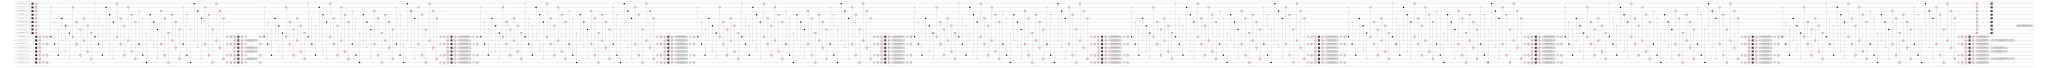

In [74]:
circuit.diagram('timeline-svg')

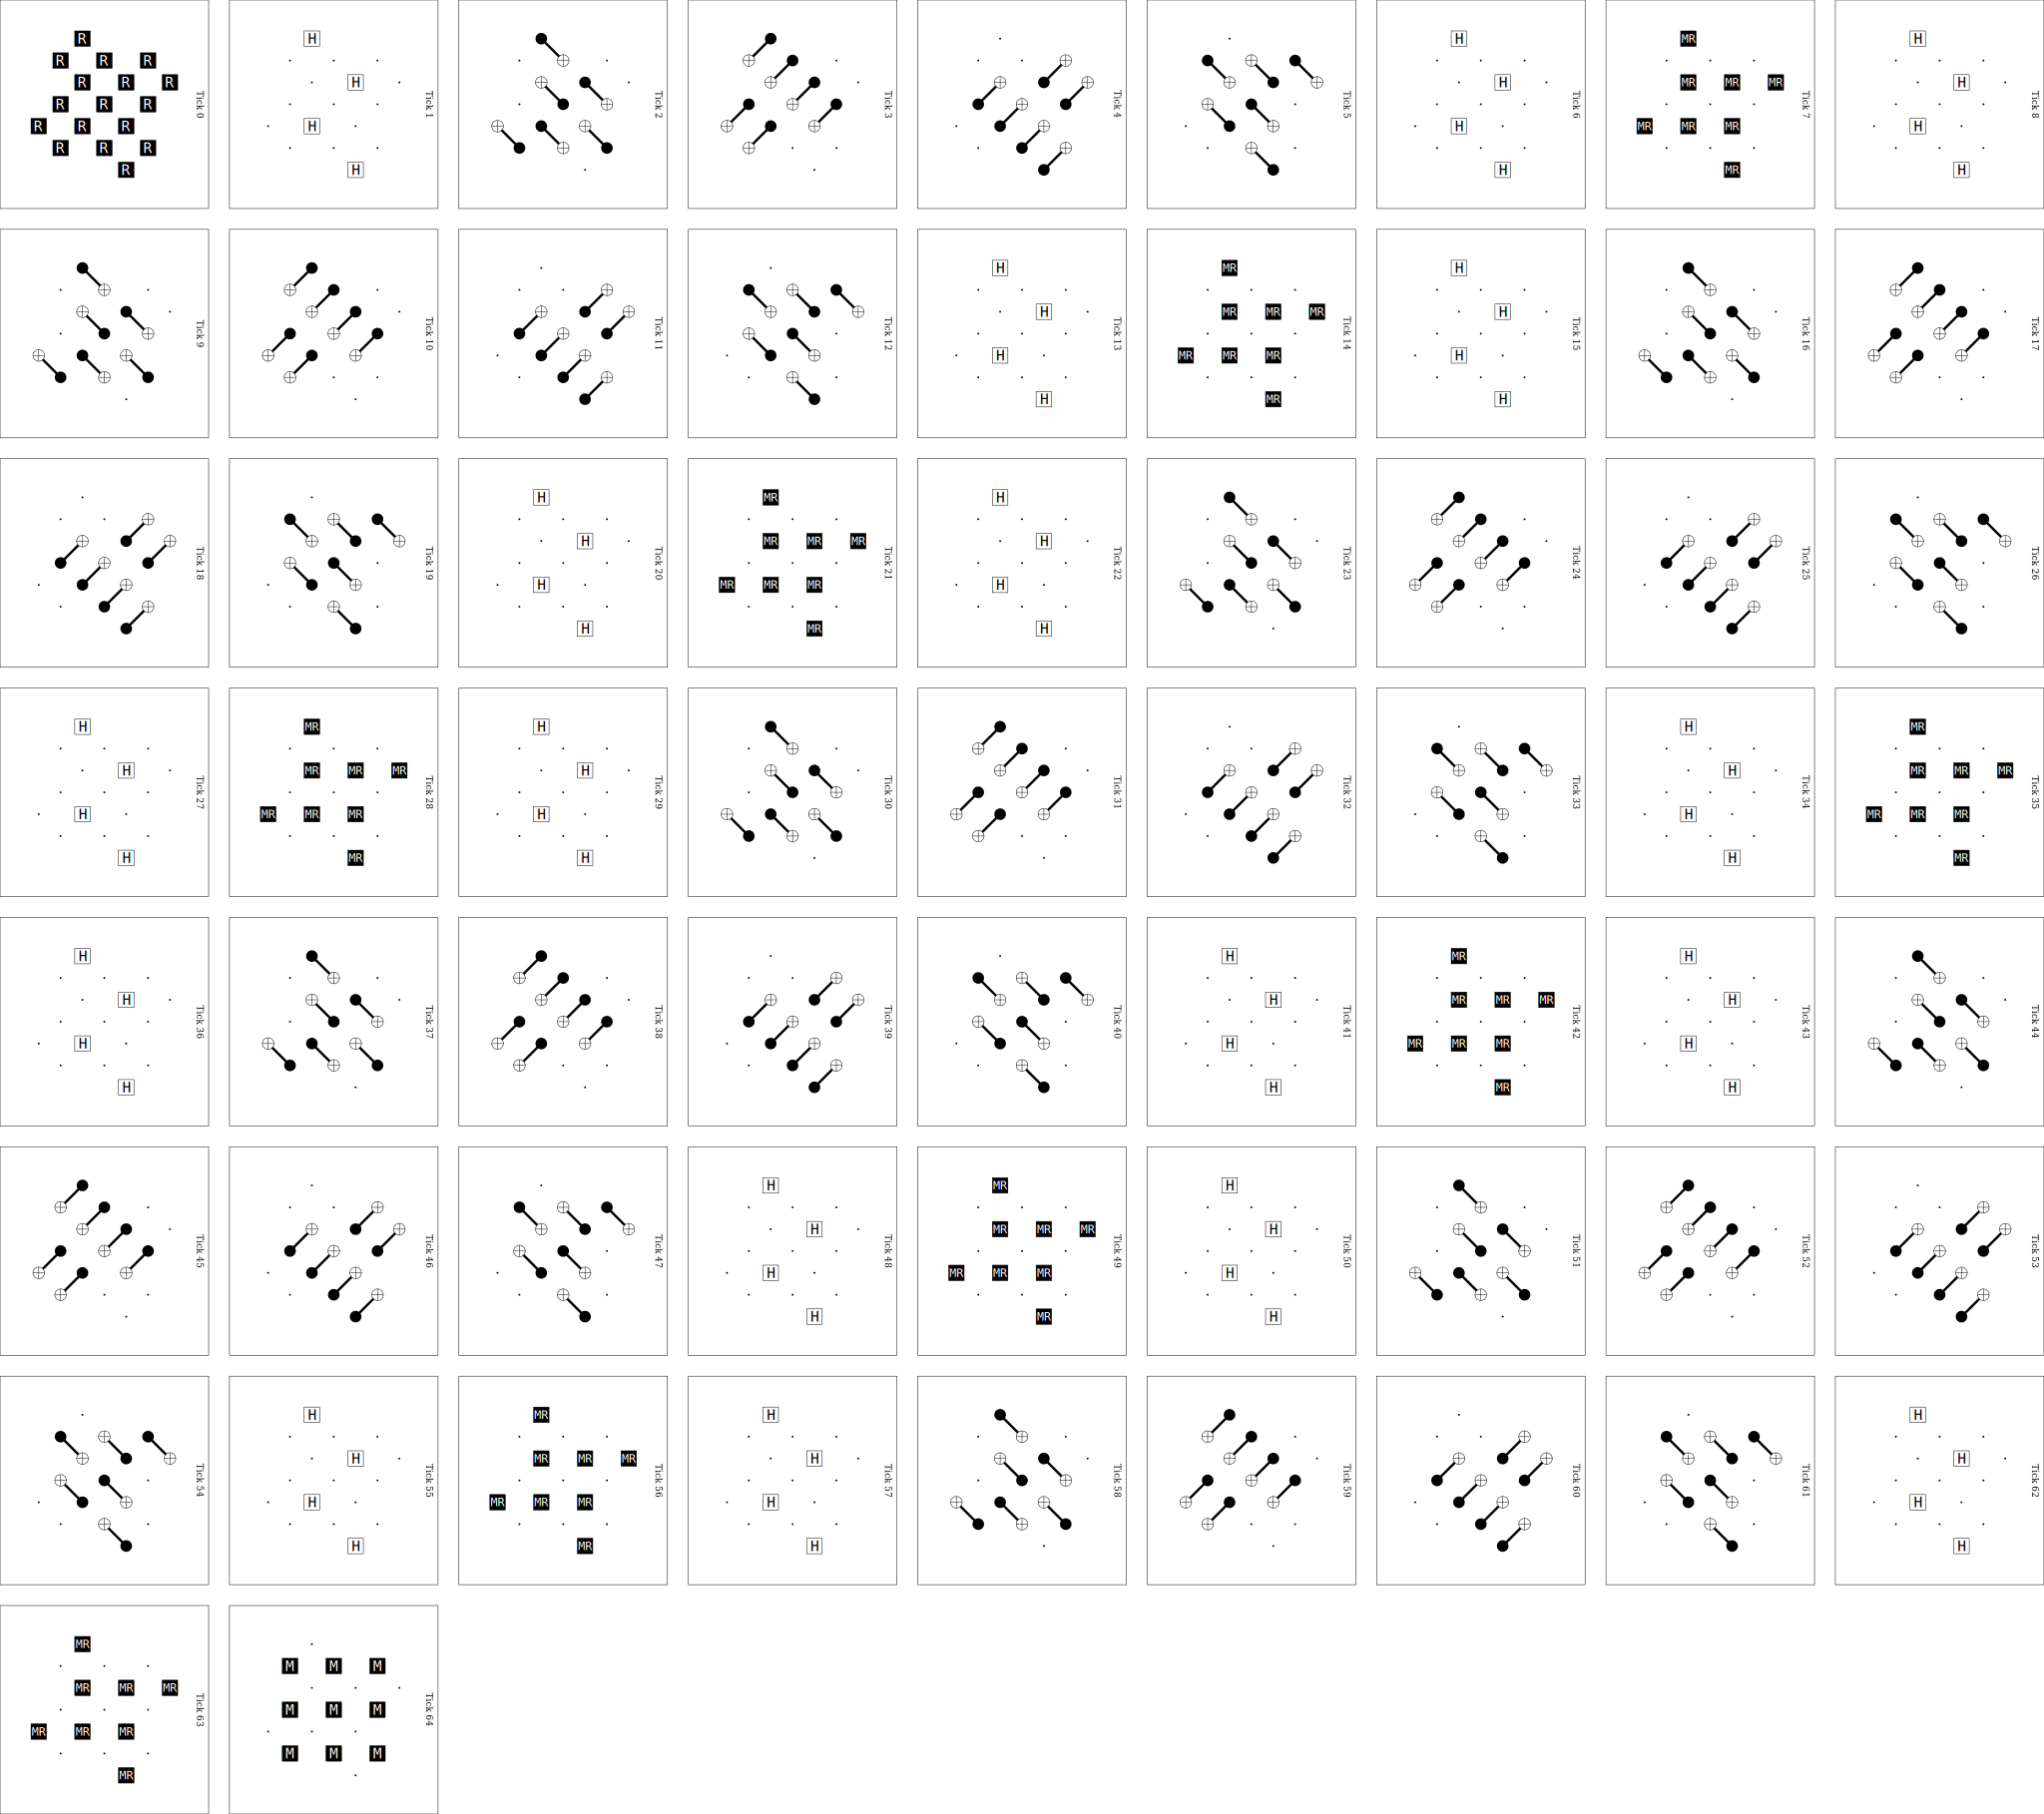

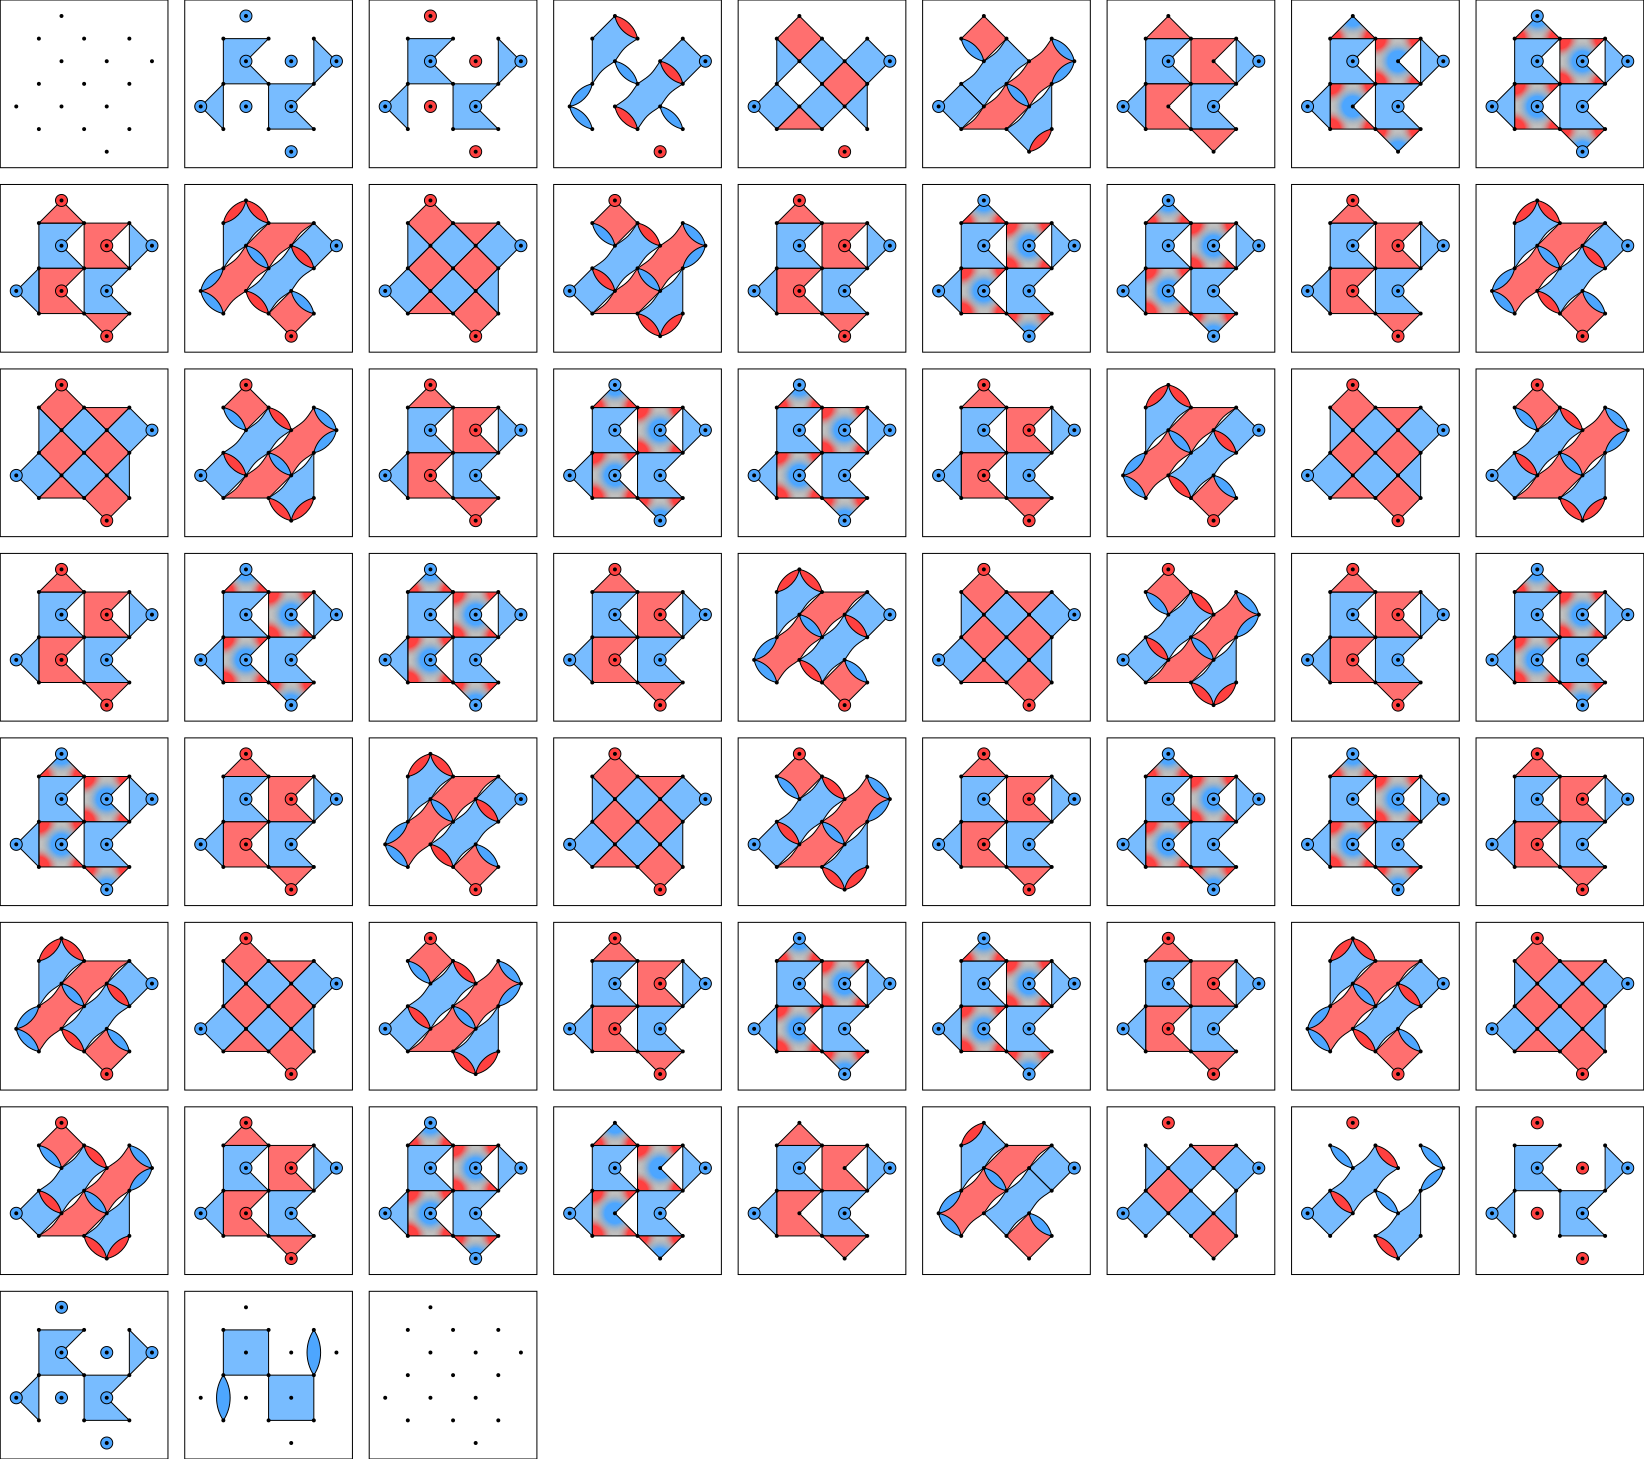

In [ ]:
circuit.diagram("detslice-svg")

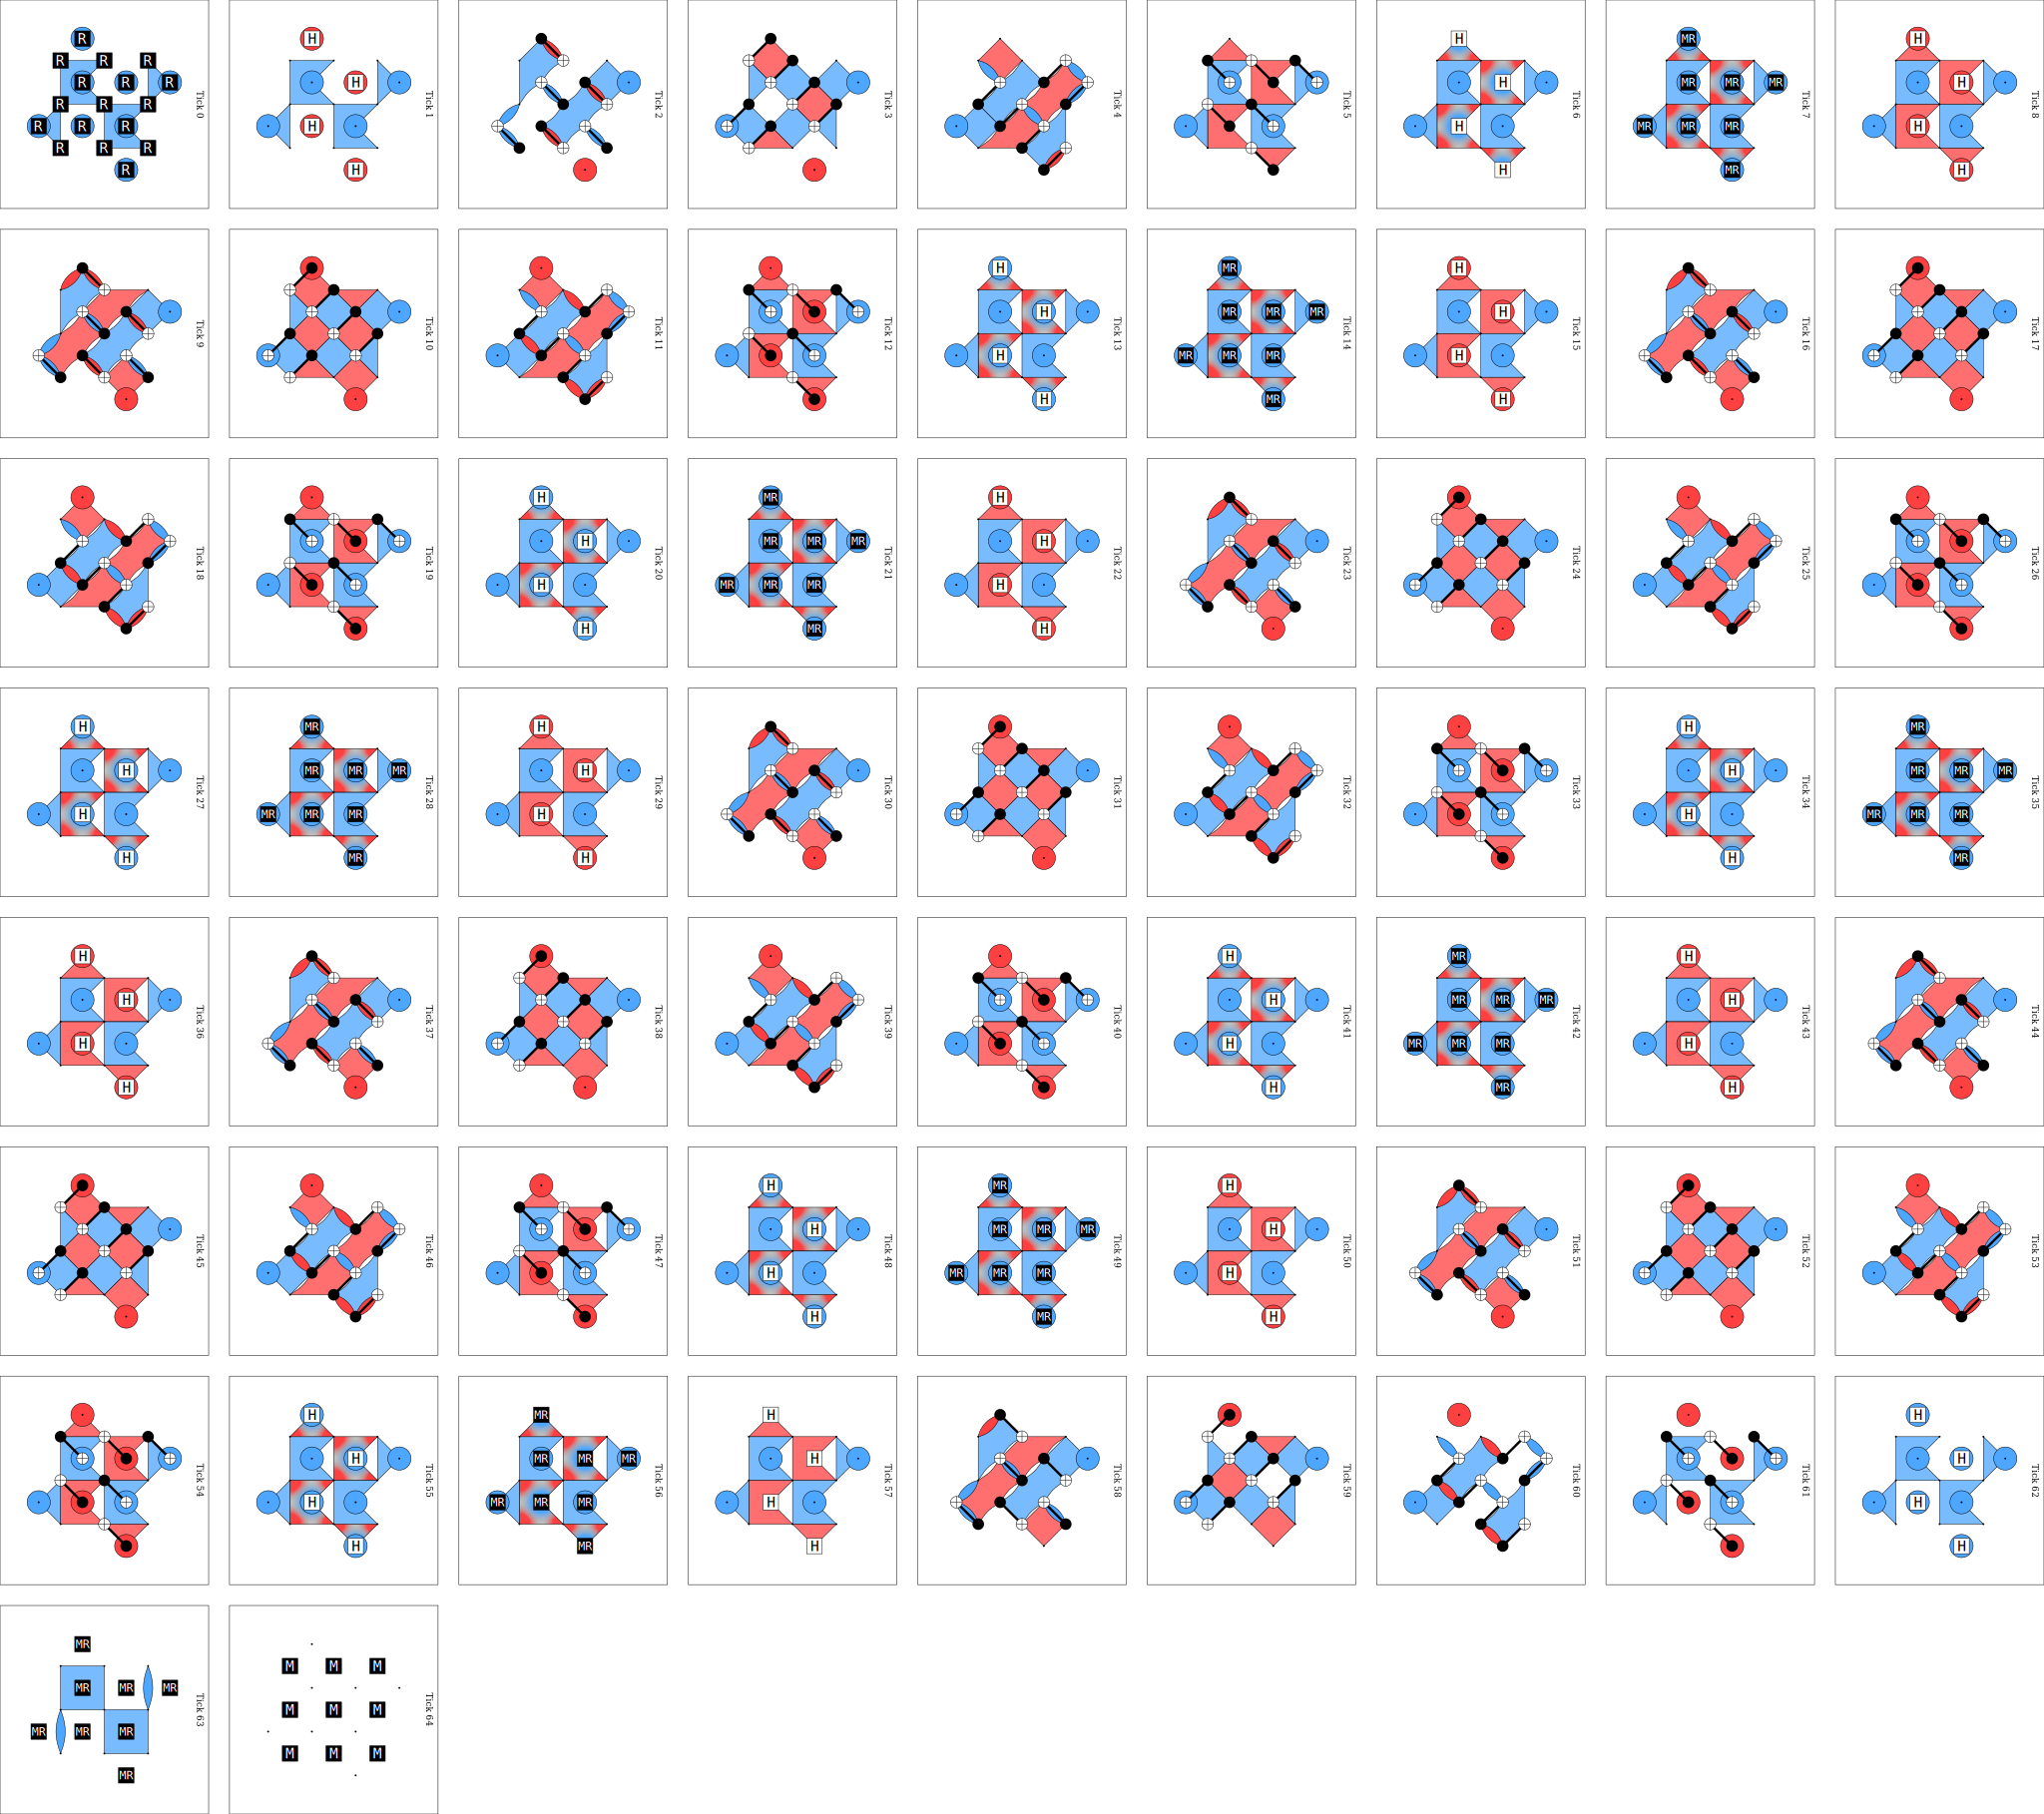

In [ ]:
circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)

In [ ]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [ ]:
noise_list = [0.001,0.004,0.005,0.006,0.007,0.008, 0.009, 0.01, 0.011, 0.012, 0.013]
surface_code_tasks = [
    sinter.Task(
        circuit = make_surface_code_circuit(distance=d,rounds=d*3,lookback_distance=1,noise=noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in noise_list
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

{10: [4, 1, 3, 0], 12: [5, 2], 13: [6, 3], 15: [8, 5, 7, 4]}
[stim.target_rec(-5), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-9), stim.target_rec(-16)]
[stim.target_rec(-4), stim.target_rec(-7), stim.target_rec(-14)]
[stim.target_rec(-3), stim.target_rec(-6), stim.target_rec(-13)]
[stim.target_rec(-1), stim.target_rec(-4), stim.target_rec(-2), stim.target_rec(-5), stim.target_rec(-11)]
{10: [4, 1, 3, 0], 12: [5, 2], 13: [6, 3], 15: [8, 5, 7, 4]}
[stim.target_rec(-5), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-9), stim.target_rec(-16)]
[stim.target_rec(-4), stim.target_rec(-7), stim.target_rec(-14)]
[stim.target_rec(-3), stim.target_rec(-6), stim.target_rec(-13)]
[stim.target_rec(-1), stim.target_rec(-4), stim.target_rec(-2), stim.target_rec(-5), stim.target_rec(-11)]
{10: [4, 1, 3, 0], 12: [5, 2], 13: [6, 3], 15: [8, 5, 7, 4]}
[stim.target_rec(-5), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-9), stim.target_rec(-16)]
[stim.target_rec(-4), 

KeyboardInterrupt: 

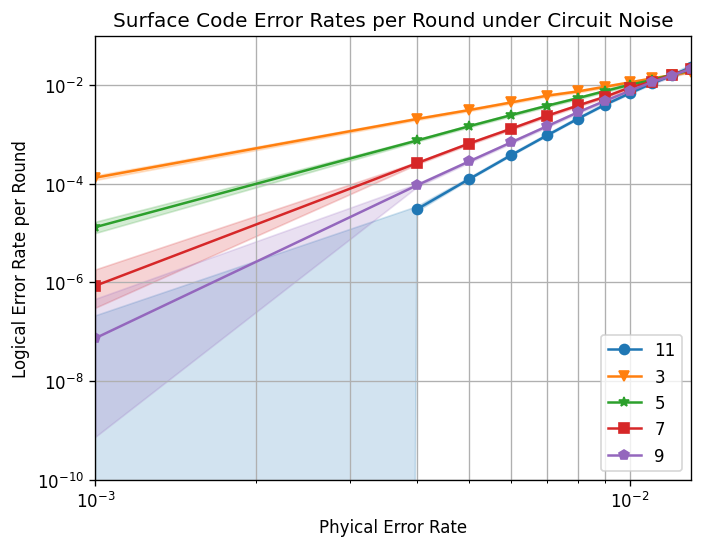

In [ ]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(1e-10, 0.1)
ax.set_xlim(min(noise_list), max(noise_list))
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger